In [5]:
# Ensure Mac ARM chip is used as GPU
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
with tf.device('/GPU:0'):
    a = tf.constant([1.0, 2.0, 3.0])
    b = tf.constant([4.0, 5.0, 6.0])
    c = a * b
    print(c)

tf.Tensor([ 4. 10. 18.], shape=(3,), dtype=float32)


## This notebook focuses on different ways to embed text as vectors using the Keras library

In essence, the Embedding layer is like a dictionary that maps integer indices to dense vectors:

Word index -> Embedding layer -> Corresponding word vector

In [47]:
from keras.layers import Embedding
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras import preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import numpy as np
import os

In [9]:
# Loading the data
# Only loads the 10,000 most common words
max_features = 10000
maxlen = 20
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [13]:
model = Sequential()

# 10000 - the number of possible tokens
# 8 - the dimensionality of the encodings
model.add(Embedding(10000, 8, input_length=maxlen))

model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

model.summary()

history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 8)             80000     
                                                                 
 flatten_2 (Flatten)         (None, 160)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 161       
                                                                 
Total params: 80161 (313.13 KB)
Trainable params: 80161 (313.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 5s 7ms/step - loss: 0.6698 - acc: 0.6205 - val_loss: 0.6233 - val_acc: 0.6954
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5479 - acc: 0.7513 - val_loss: 0.5305 - val_acc: 0.7328
Epoch 3/10
625/6

The model above exhibits certain shortcomings. The biggest one is that it is unable to identify semantic connection and structure of words within a sentence. This leads to misinterpretations of natural language (i.e. "this movie is THE bomb" == "this movie is a bomb"). We will attempt better approaches using a 1-D convolutional neural network (CNN) and a recurrent neural network (RNN)

In [56]:
# Load raw text data
# -> Processing the labels of the raw IMDB data
imdb_dir = '/Users/davidriva/Desktop/Coding-Projects/Deep-Learning-Projects/text_and_sequence_processing/data/aclImdb'

train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [57]:
# Tokenizing the text of the raw IMDB data
maxlen = 100 # cut off reviews after 100 words
training_samples = 2000
validation_samples = 10000
max_words = 10000 # considers only the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences=tokenizer.texts_to_sequences(texts)

In [58]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples : training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [59]:
# Use precomputed embeddings from Stanford GloVe

glove_dir = '/Users/davidriva/Desktop/Coding-Projects/Deep-Learning-Projects/text_and_sequence_processing/data/glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [60]:
# Preparing the GloVe word-embeddings matrix
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [61]:
# Create a simple NN
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Load pretrained word embeddings into the Embedding layer
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable=False

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history=model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=[x_val, y_val])
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
63/63 [==============================] - 2s 20ms/step - loss: 0.9400 - acc: 0.5680 - val_loss: 0.7687 - val_acc: 0.5660
Epoch 2/10
63/63 [==============================] - 1s 15ms/step - loss: 0.6453 - acc: 0.6530 - val_loss: 0.9238 - val_acc: 0.5462
Epoch 3/10
63/63 [==============================] - 1s 15ms/step - loss: 0.6087 - acc: 0.7010 - val_loss: 0.7068 - val_acc: 0.6157
Epoch 4/10
63/63 [==============================] - 1s 15ms/step - loss: 0.5068 - acc: 0.7460 - val_loss: 0.7072 - val_acc: 0.6240
Epoch 5/10
63/63 [==============================] - 1s 14ms/step - loss: 0.4532 - acc: 0.8035 - val_loss: 0.7242 - val_acc: 0.6346
Epoch 6/10
63/63 [==============================] - 1s 15ms/step - loss: 0.3872 - acc: 0.8280 - val_loss: 0.8289 - val_acc: 0.6195
Epoch 7/10
63/63 [==============================] - 1s 14ms/step - loss: 0.3146 - acc: 0.8650 - val_loss: 0.7534 - val_acc: 0.6456
Epoch 8/10
63/63 [==============================] - 1s 14ms/step - loss: 0.2916 - a

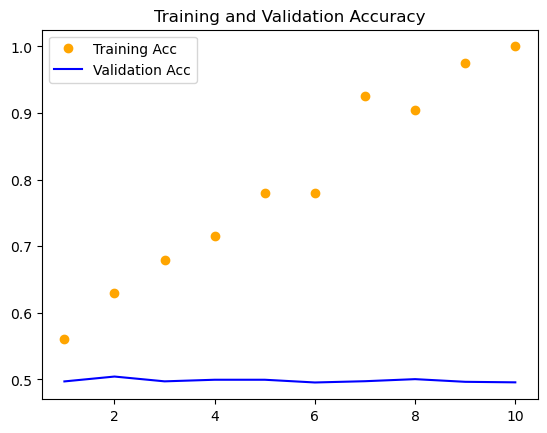

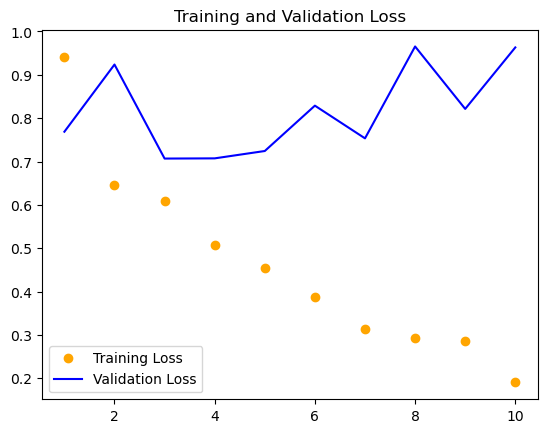

In [63]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'o', color='orange', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'o', color='orange', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [64]:
# Load test data
imdb_dir = '/Users/davidriva/Desktop/Coding-Projects/Deep-Learning-Projects/text_and_sequence_processing/data/aclImdb'

test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
                
sequences=tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [66]:
# Evaluate on test data
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 2s 3ms/step - loss: 0.8894 - acc: 0.6551


[0.8893553614616394, 0.6551200151443481]